In [2]:
import pandas as pd

In [3]:
import numpy as np

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.patches as patches
import healpy as hp
from matplotlib.patches import Circle

In [5]:
from scipy.signal import savgol_filter

In [6]:
from datetime import datetime
from zoneinfo import ZoneInfo

In [7]:
from astroquery.hips2fits import hips2fits
from astroquery.vizier import Vizier
import astropy.units as u
from astropy.coordinates import Longitude, Latitude, Angle, SkyCoord, EarthLocation, AltAz, Galactic, SpectralCoord, LSR
from astropy.time import Time
from astropy.constants import c 
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize

In [8]:
df = pd.read_csv("25-aug-hline.csv", sep=",") 

In [9]:
fft_size = df.iloc[0]["FFT Size"]
center_frequency = df.iloc[0]["Centre Freq"]
sample_rate = df.iloc[0]["Sample Rate"]
resolution = sample_rate / fft_size
offset = np.arange(fft_size) * resolution - sample_rate / 2
frequencies = center_frequency + offset

In [10]:
data_idx = df.columns.get_loc("Data")

In [11]:
spectra = []
for i in range(len(df)):
    row = df.iloc[i]
    datetime_data = row["Date Time"]
    power_data = row["Power (dBFS)"]
    data = row.tolist()[data_idx:data_idx + fft_size]
    spectra.append({"datetime": datetime_data, "power": power_data, "data": np.array(data)})
spectra = np.array(spectra)

In [12]:
for i in range(len(spectra)):
    current = spectra[i];
    spectra[i]["data"] = current["data"] / (-1 * current["power"])

In [74]:
n_bg = 3
bg_spectra = (list(curr["data"] for curr in spectra))[:n_bg]
bg_mean = np.mean(bg_spectra, axis=0)

In [267]:
n_average = 3
averaged_spectra_snr = []
n_all = len(df) - n_bg
n_done = n_bg
std = np.std(bg_mean)

while n_all - n_average > n_done:
    spectra_with_time = spectra[n_done:n_done + n_average]
    spectra_datetime = spectra_with_time[0]["datetime"]
    spectral_data = list(curr["data"] for curr in spectra_with_time)
    signal_mean = np.mean(spectral_data, axis=0)
    diff = (signal_mean - bg_mean) / std
    smoothed_snr = savgol_filter(diff, 5, 3)
    averaged_spectra_snr.append({"datetime": spectra_datetime, "data": diff}) # no-filter!
    n_done += n_average

In [76]:
current_az = 0.0
current_alt = 90.0 
location = EarthLocation(lat=47.1368*u.deg, lon=7.2468*u.deg, height=437*u.m)

In [77]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [281]:
v_actual = []
v_measured = []

for i in range(len(averaged_spectra_snr)):
    current_spectra = averaged_spectra_snr[i]
    iso_time = datetime.strptime(current_spectra["datetime"], "%a %b %d %H:%M:%S %Y")
    local_time = iso_time.replace(tzinfo=ZoneInfo("Europe/Zurich")) 
    utc_time = local_time.astimezone(ZoneInfo("UTC"))
    time = Time(utc_time)
    
    altaz_frame = AltAz(obstime=time, location=location)
    current_pointing = SkyCoord(az=current_az*u.deg, alt=current_alt*u.deg, frame=altaz_frame)
    current_radec = current_pointing.transform_to('icrs')
    current_gal = current_pointing.transform_to(Galactic)
    l_deg = current_gal.l.deg
    b_deg = current_gal.b.deg
    
    observer_location = location.get_itrs(time)
    
    # Thanks to https://github.com/byggemandboesen/H-line-software which helped me to transform the RV relative to LSR
    
    resting_freq = 1420405751.77 * u.Hz
    h_freq = u.doppler_radio(resting_freq)
    measured_freq = frequencies[savgol_filter(current_spectra["data"], 70, 10).argmax()] * u.Hz
    
    spectral_coord = SpectralCoord(measured_freq,
                            observer=observer_location,
                            target=current_pointing,
                            doppler_convention="radio",
                            doppler_rest=resting_freq)
    
    lsr = spectral_coord.with_observer_stationary_relative_to("lsr")
    rv_lsr = lsr.to(u.km/u.s, equivalencies=h_freq)

    # Download from http://cade.irap.omp.eu/dokuwiki/doku.php?id=hi4pi
    loaded_map = hp.read_map("HI4PI_MOM1_GAL_1_1024.fits") 
    theta = np.radians(90.0 - b_deg)  # colatitude
    phi   = np.radians(l_deg)         # longitude
    vec = hp.ang2vec(theta, phi)
    nside_map = hp.get_nside(loaded_map);
    ipix_disc = hp.query_disc(nside=nside_map, vec=vec, radius=np.radians(30))
    intensities = loaded_map[ipix_disc]
    
    #print("Actual: " + str(np.median(intensities)) + ", Measured: " + str(rv_lsr.value))
    v_actual.append(np.median(intensities))
    v_measured.append(np.median(rv_lsr.value))

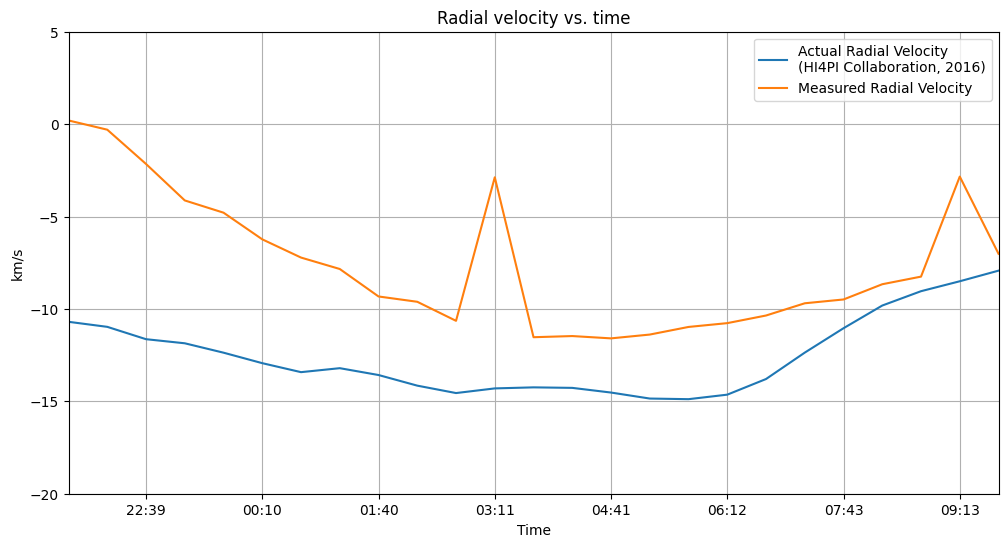

In [282]:
dates = [':'.join(current['datetime'].split(" ")[3].split(":")[:2]) for current in averaged_spectra_snr]

plt.figure(figsize=(12, 6))

plt.plot(dates, v_actual, label='Actual Radial Velocity \n(HI4PI Collaboration, 2016)')
plt.plot(v_measured, label='Measured Radial Velocity')

plt.title('Radial velocity vs. time')
plt.xlabel('Time')
plt.ylabel('km/s')
plt.ylim(-20, 5)
plt.xticks(dates[::3])
plt.xlim(10, 34)
plt.legend()  
plt.grid(True)  

plt.show()

<Figure size 1200x500 with 0 Axes>

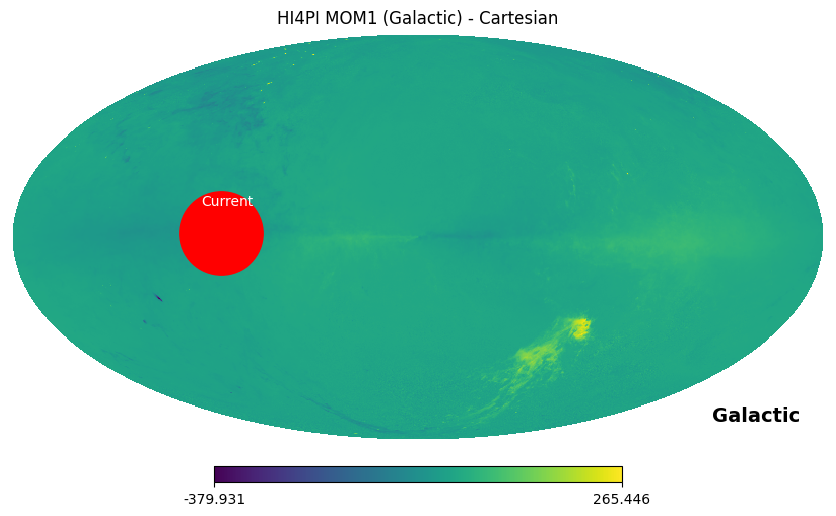

Values mean: -18.370045, time: 2025-08-25 22:10:20


In [276]:
current_spectra = averaged_spectra_snr[15]

iso_time = datetime.strptime(current_spectra["datetime"], "%a %b %d %H:%M:%S %Y")
local_time = iso_time.replace(tzinfo=ZoneInfo("Europe/Zurich")) 
utc_time = local_time.astimezone(ZoneInfo("UTC"))
time = Time(utc_time)

altaz_frame = AltAz(obstime=time, location=location)
current_pointing = SkyCoord(az=current_az*u.deg, alt=current_alt*u.deg, frame=altaz_frame)
current_radec = current_pointing.transform_to('icrs')
current_gal = current_pointing.transform_to(Galactic)
l_deg = current_gal.l.deg
b_deg = current_gal.b.deg

loaded_map = hp.read_map("HI4PI_MOM1_GAL_1_1024.fits") 

theta = np.radians(90.0 - b_deg)  
phi   = np.radians(l_deg)        
vec = hp.ang2vec(theta, phi)

ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(30))
intensities = loaded_map[ipix_disc]

plt.figure(figsize=(12, 5))
hp.mollview(
    loaded_map,
    coord='G',
    title='HI4PI MOM1 (Galactic) - Cartesian',
    cmap='viridis',
)

hp.visufunc.projplot(
    l_deg, b_deg,  
    lonlat=True,   
    coord='G',     
    color='red',   
    marker='o', 
    markersize=60,
)
circle = hp.visufunc.projtext(
    l_deg + 10, b_deg + 10, "Current", lonlat=True, color="white"
)

plt.show()
print("Values mean: " + str(np.mean(intensities)) + ", time: " + str(time))

In [283]:
# Download from http://cade.irap.omp.eu/dokuwiki/doku.php?id=hi4pi
h_map = hp.read_map("HI4PI_MOM0_GAL_1_1024.fits") 

def create_spectra(i):
    current_spectra = averaged_spectra_snr[i]
    iso_time = datetime.strptime(current_spectra["datetime"], "%a %b %d %H:%M:%S %Y")
    local_time = iso_time.replace(tzinfo=ZoneInfo("Europe/Zurich")) 
    utc_time = local_time.astimezone(ZoneInfo("UTC"))
    time = Time(iso_time)
    altaz_frame = AltAz(obstime=time, location=location)
    current_pointing = SkyCoord(az=current_az*u.deg, alt=current_alt*u.deg, frame=altaz_frame)
    current_radec = current_pointing.transform_to('icrs')
    current_gal = current_pointing.transform_to(Galactic)
    l_deg = current_gal.l.deg
    b_deg = current_gal.b.deg
    
    fig, ax = plt.subplots(
        nrows=1, 
        ncols=2, 
        figsize=(15, 5),
        gridspec_kw={'width_ratios': [1.5, 2]},
        constrained_layout=True
    )
    
    ax[1].plot(frequencies / 1e6, current_spectra["data"], linewidth=1)
    ax[1].set_ylim(-0.2, 2.8)
    ax[1].set_title('Frequency vs. SNR')
    ax[1].set_xlabel('Frequency (MHz)')
    ax[1].set_ylabel('SNR')
    ax[1].grid(True, alpha=0.3)

    plt.axes(ax[0])
    
    hp.gnomview(
        h_map,
        rot=[l_deg, b_deg],
        coord='G',
        title='Radio Telescope Direction',
        cmap='viridis',
        reso=12,
        hold=True,
        notext=True
    )

    plt.text(0, -0.3, 'Moment-0 Map\nHI4PI Collaboration, 2016', fontsize = 8, color='white')

    plt.suptitle('Hydrogen Line Observation ' + current_spectra["datetime"], x=0.6)
    
    return plt
    plt.show()

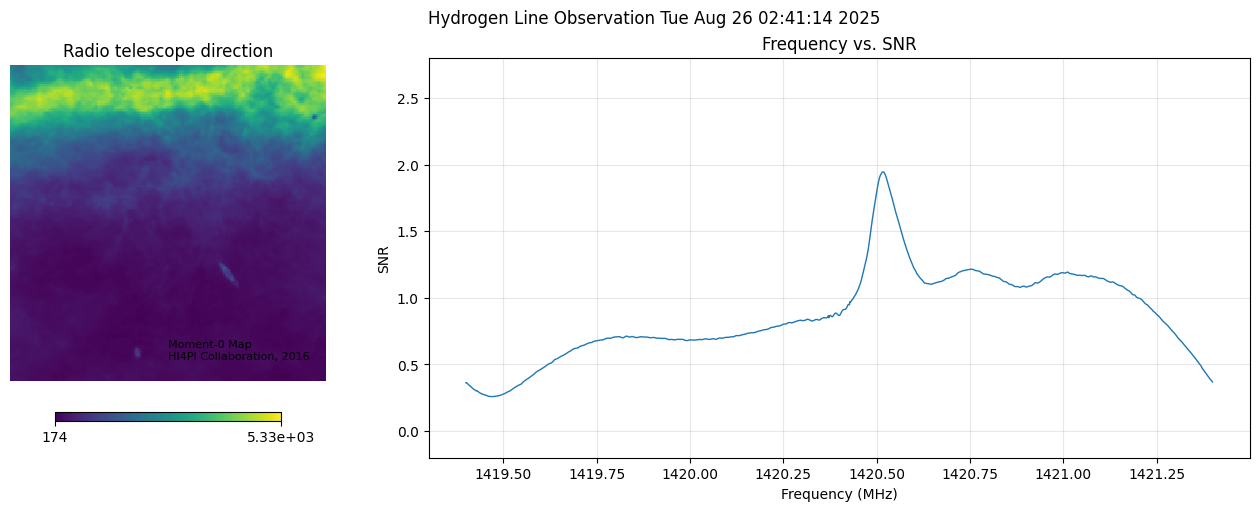

In [266]:
create_spectra(20).show()

/tmp/ipykernel_5401/3623706703.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(


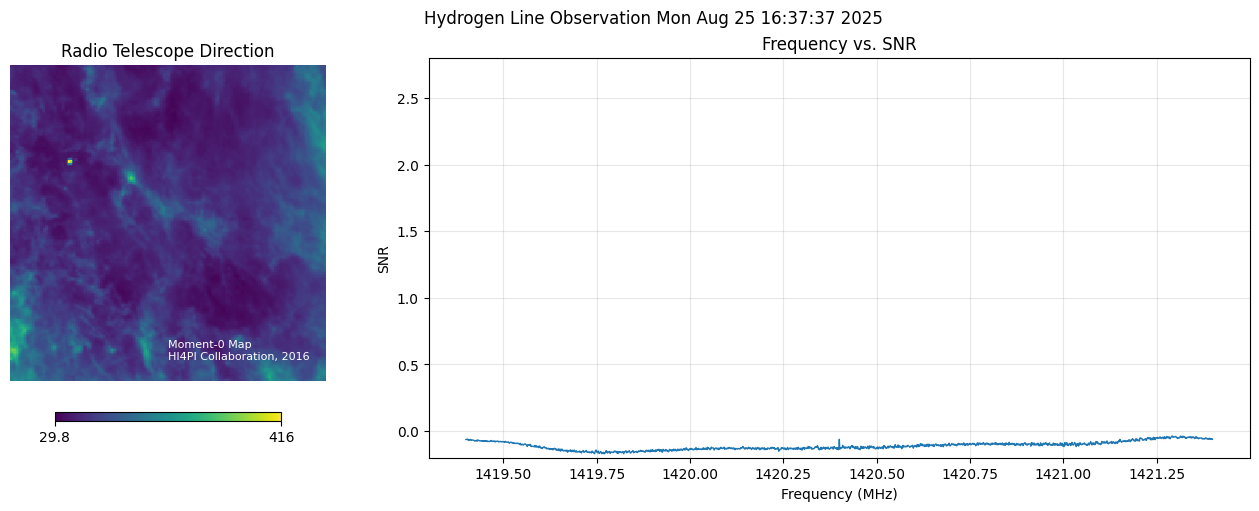

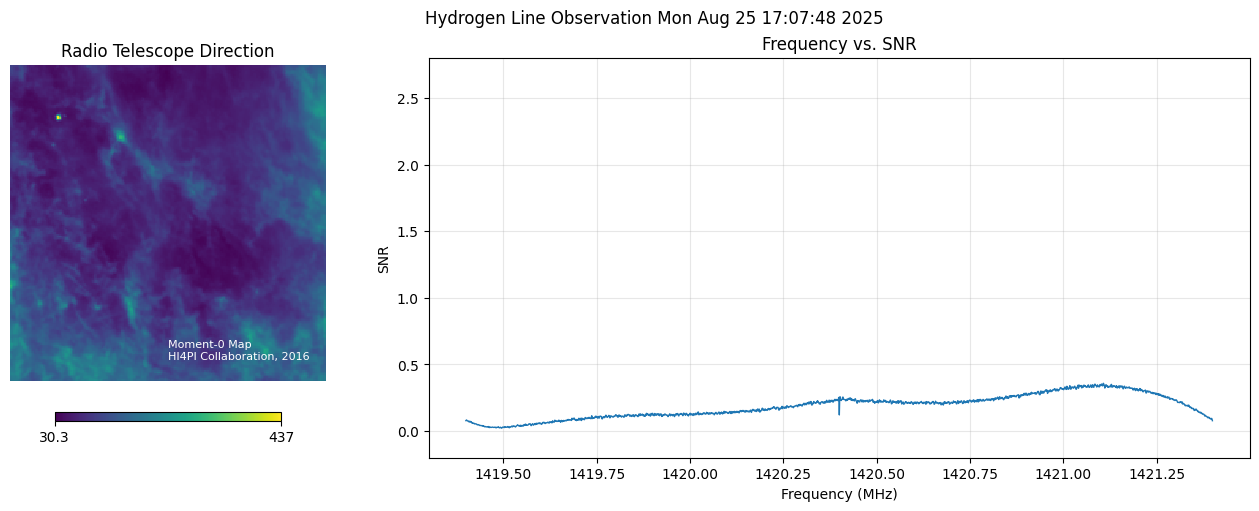

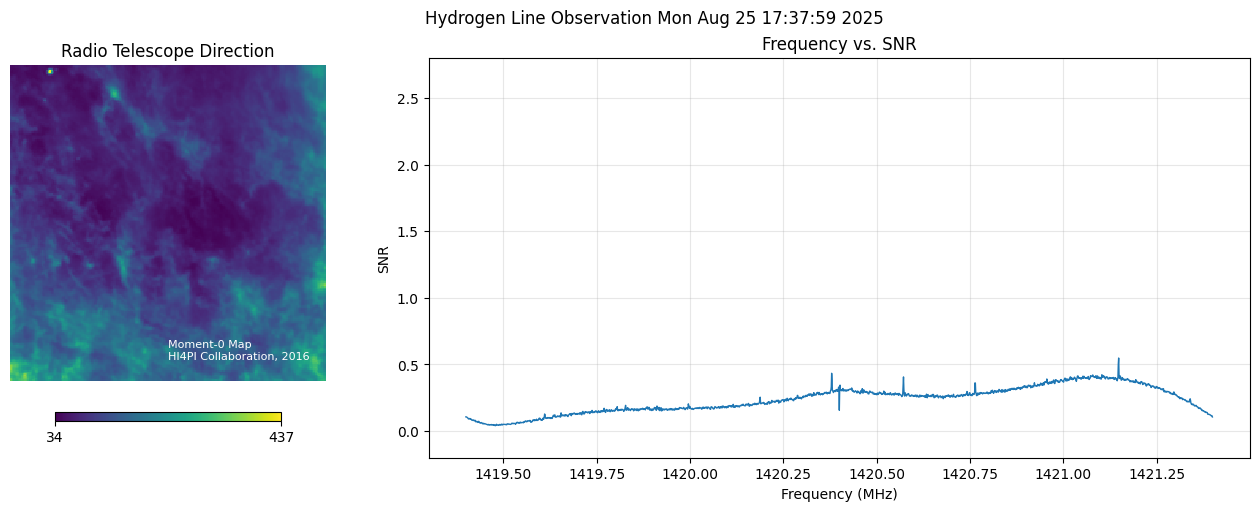

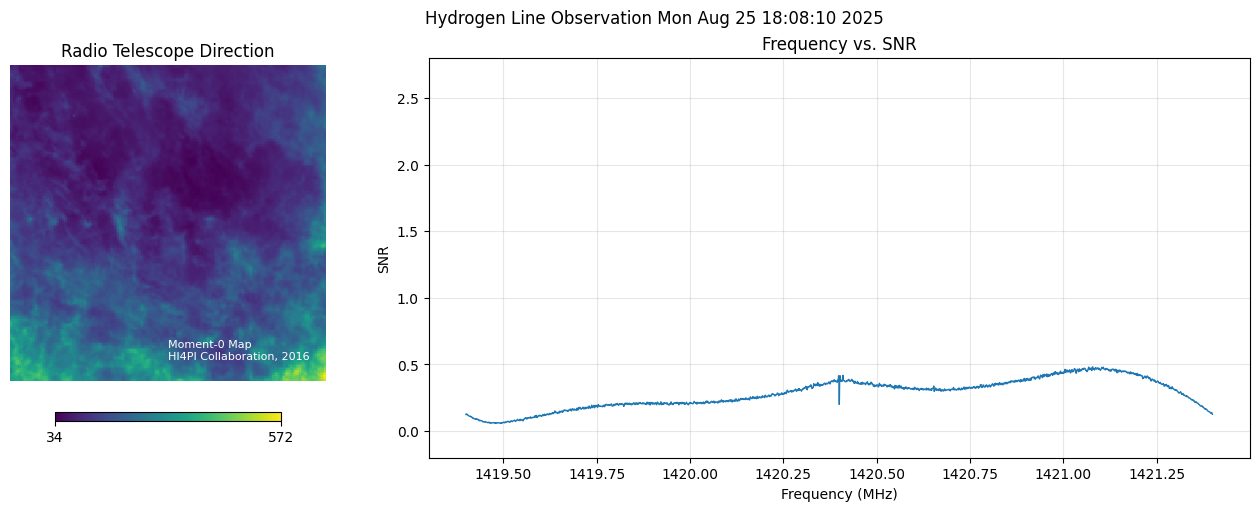

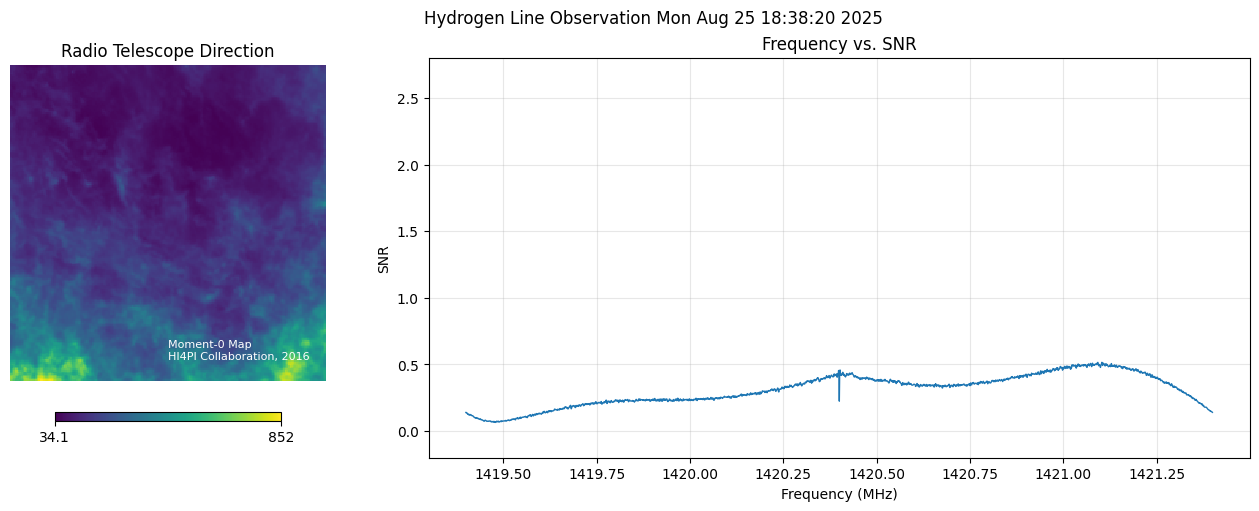

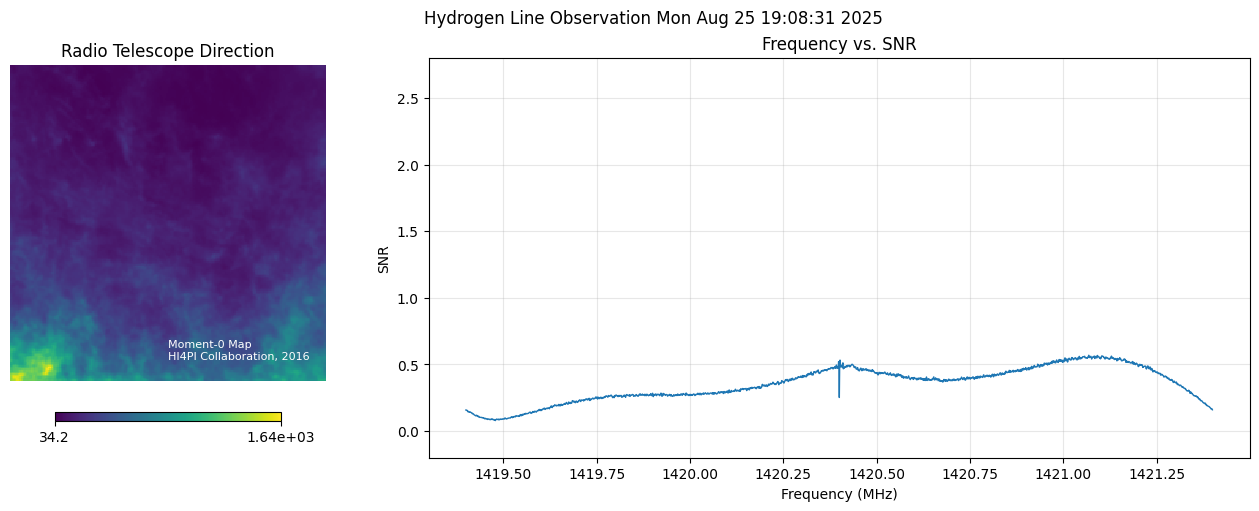

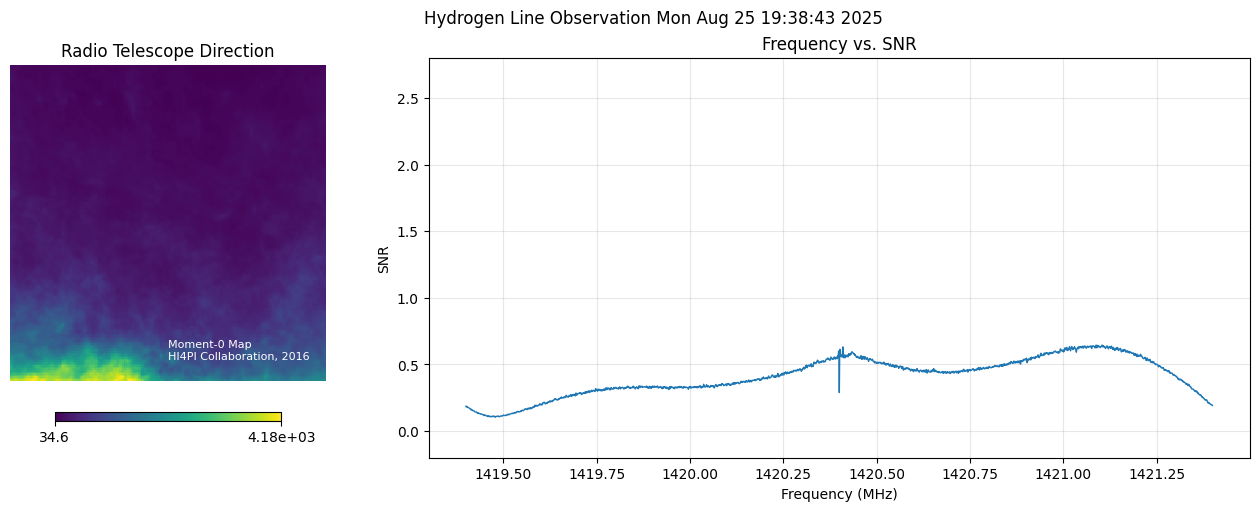

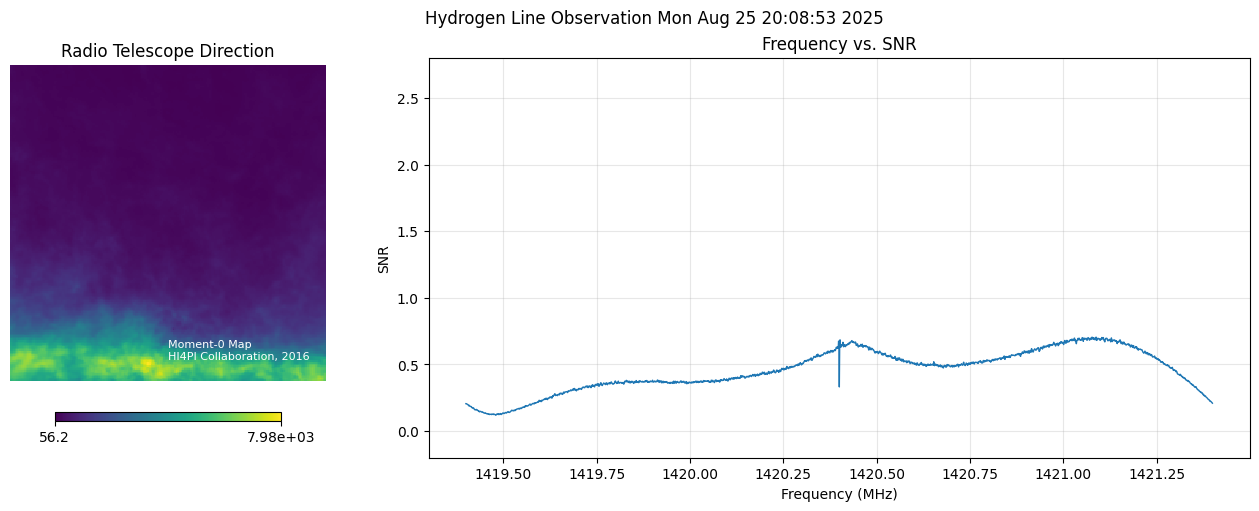

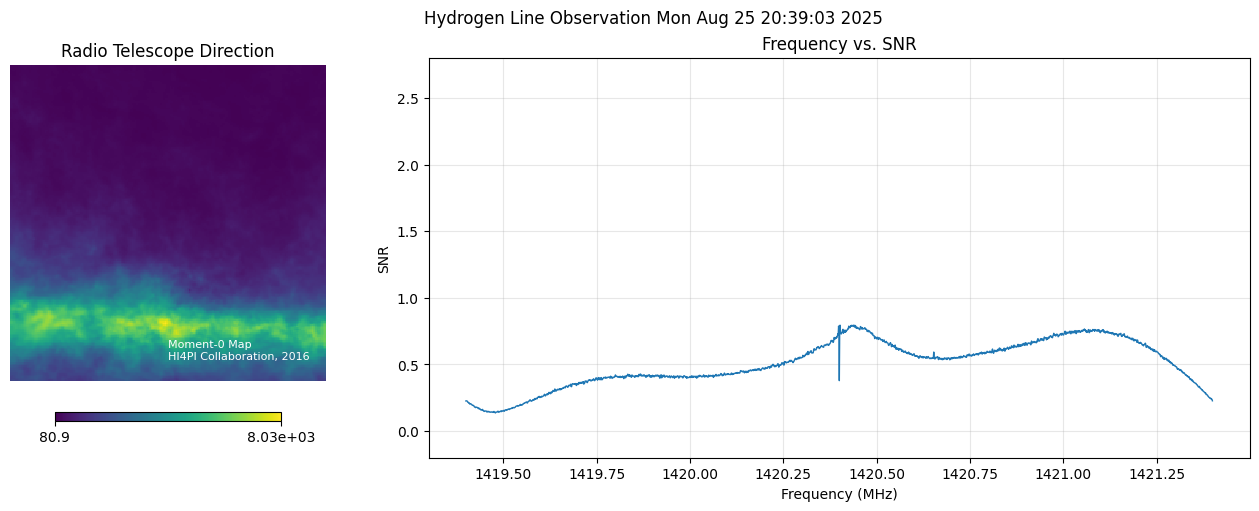

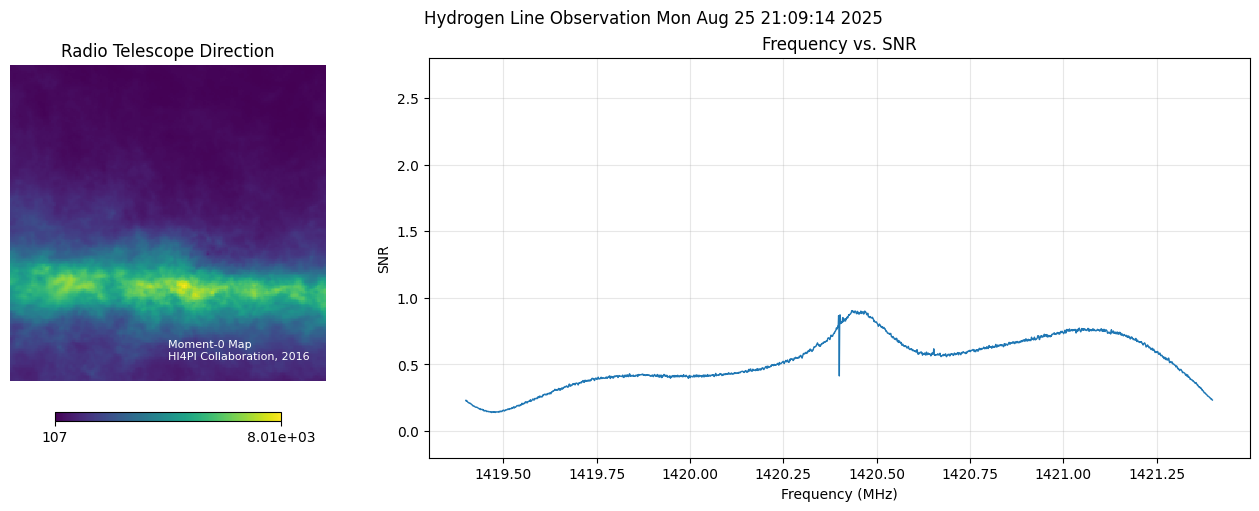

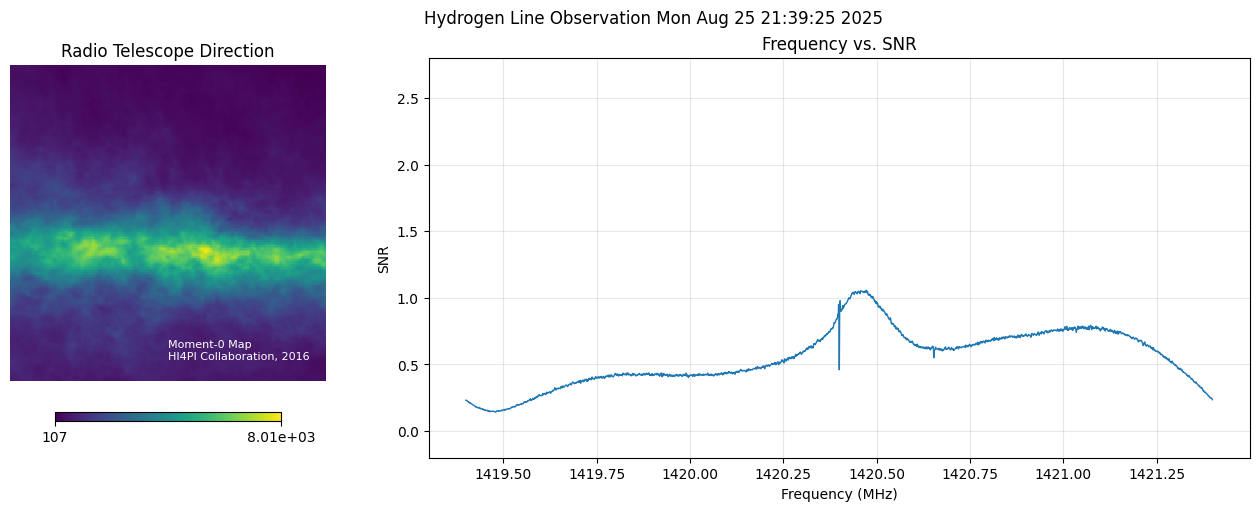

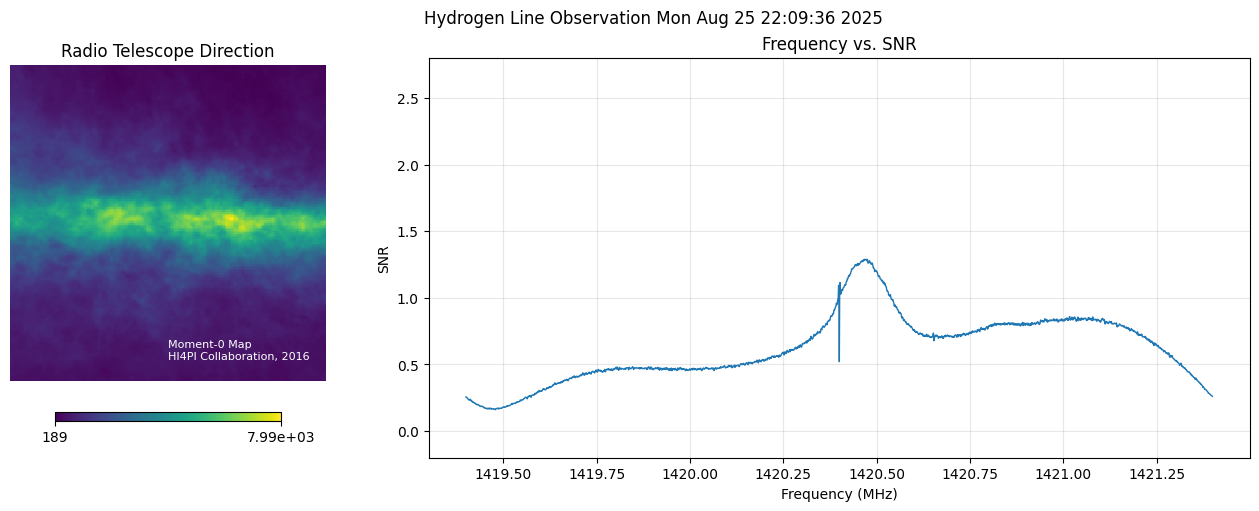

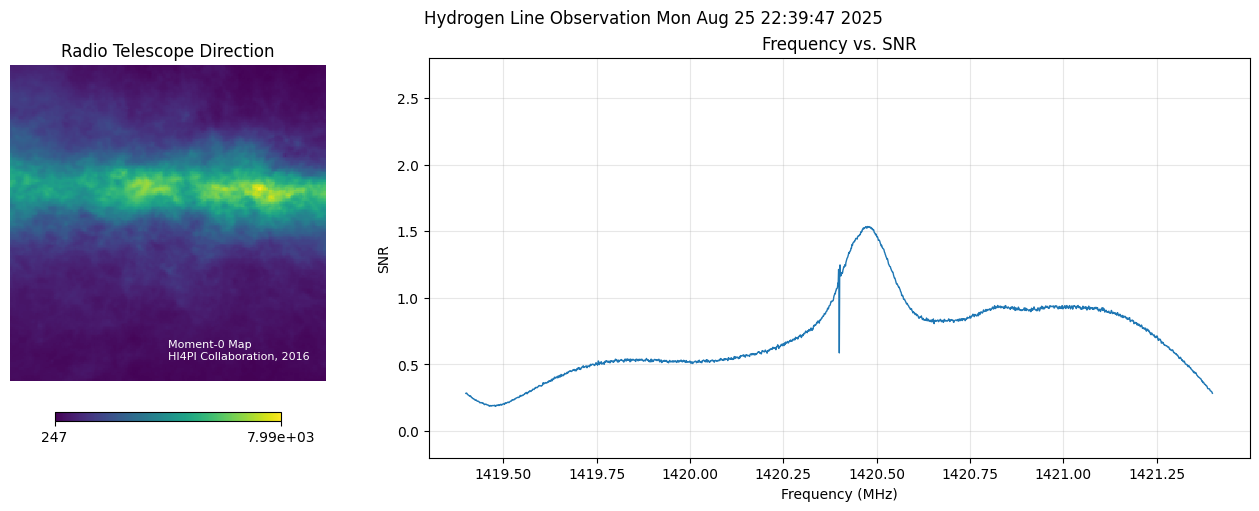

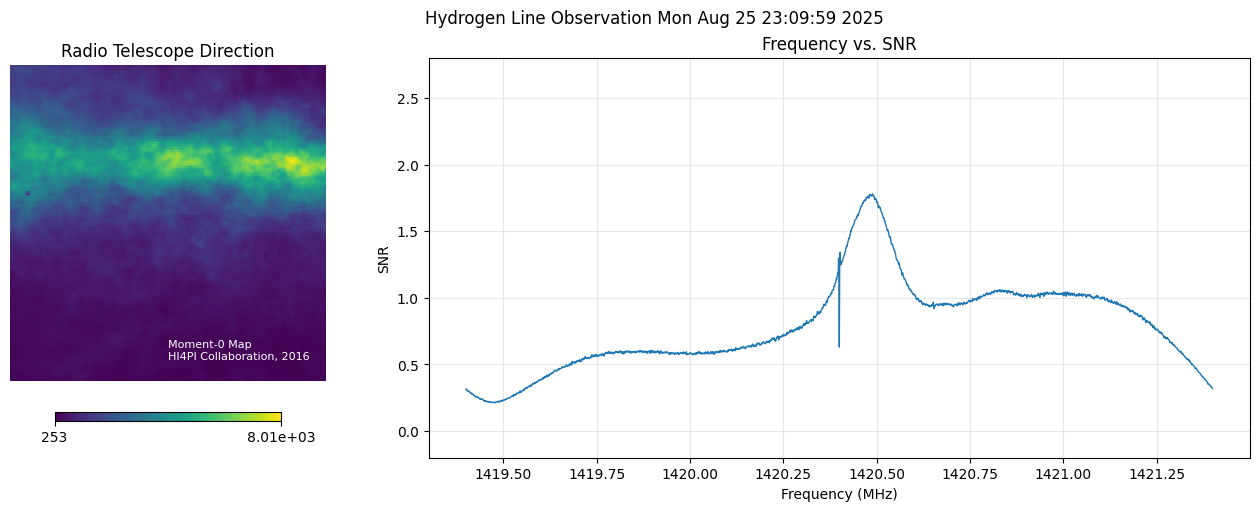

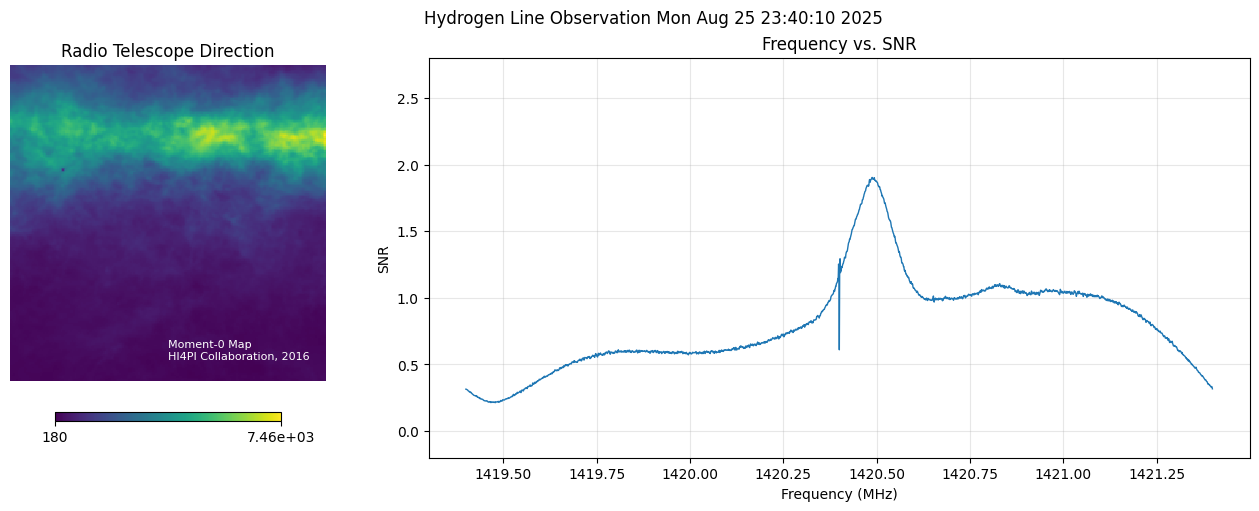

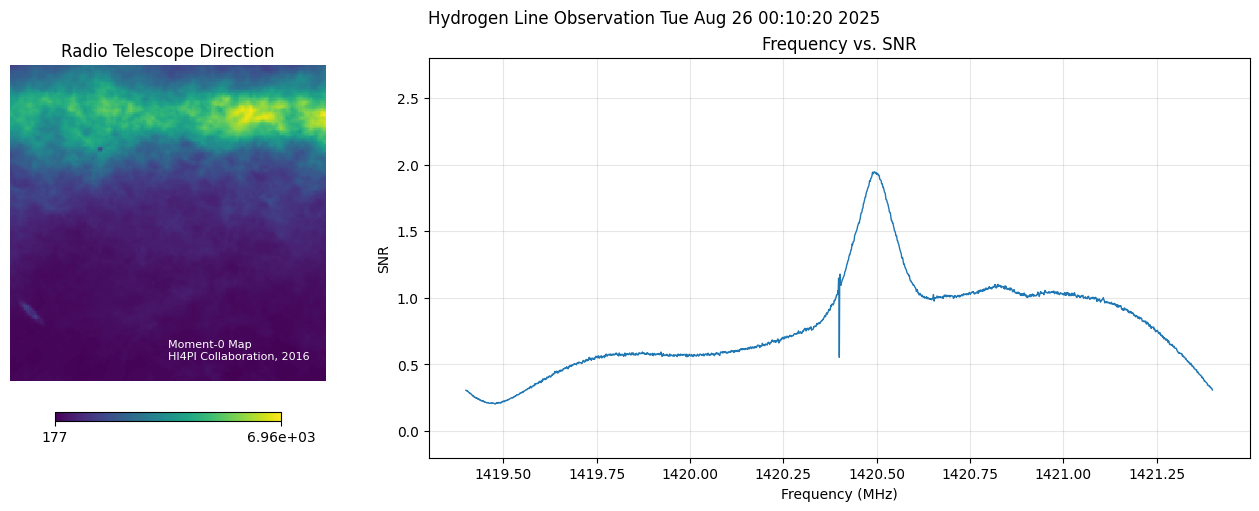

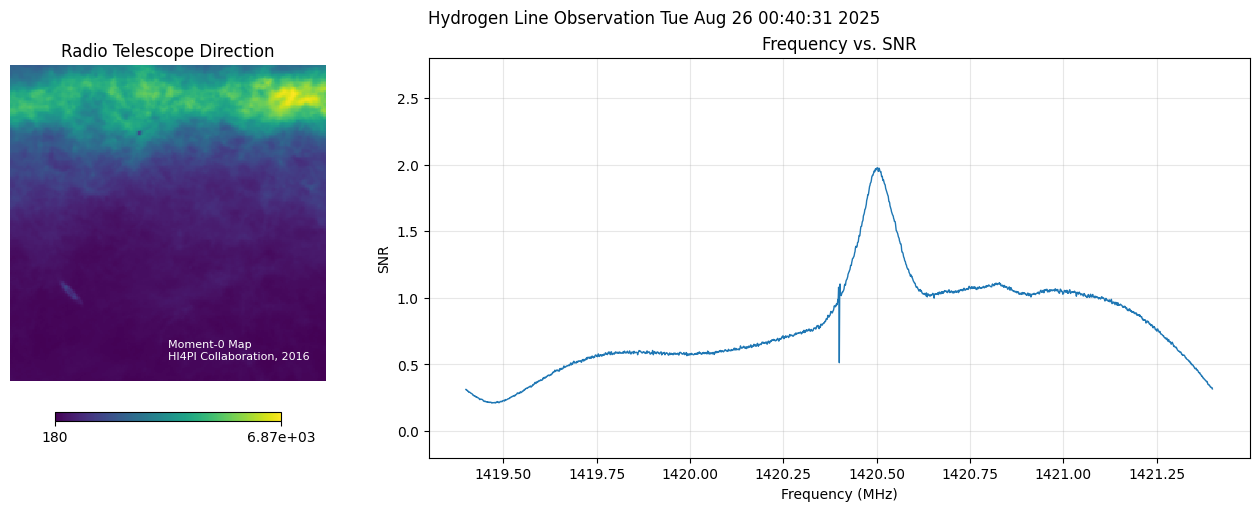

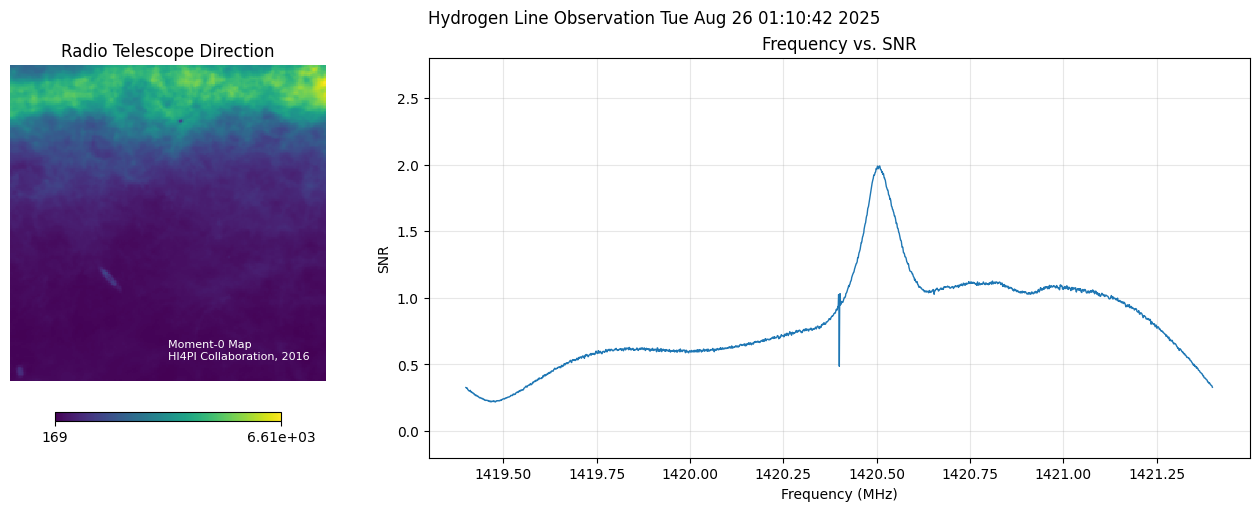

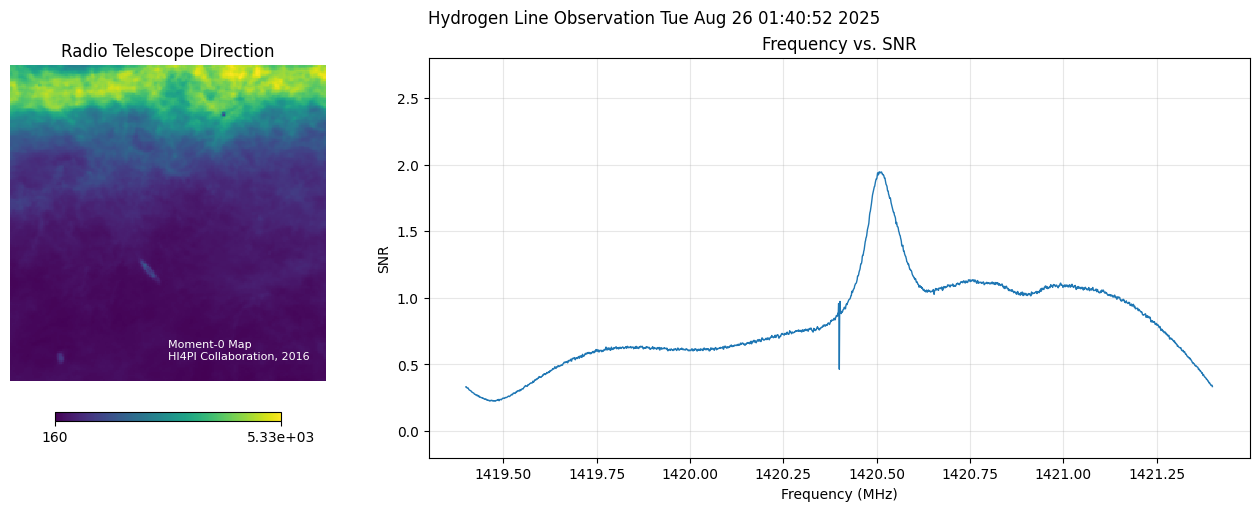

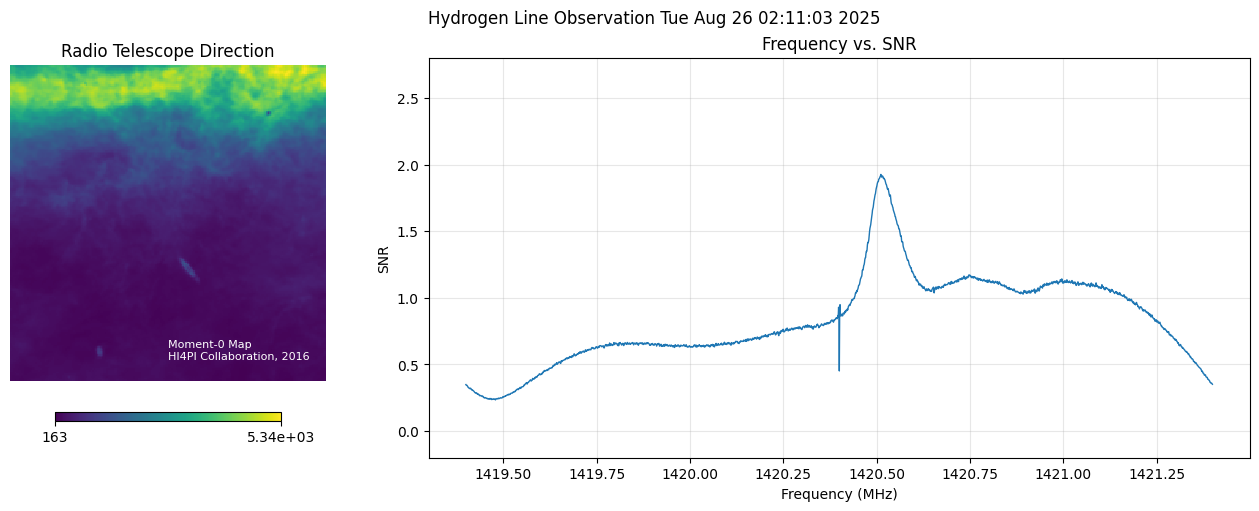

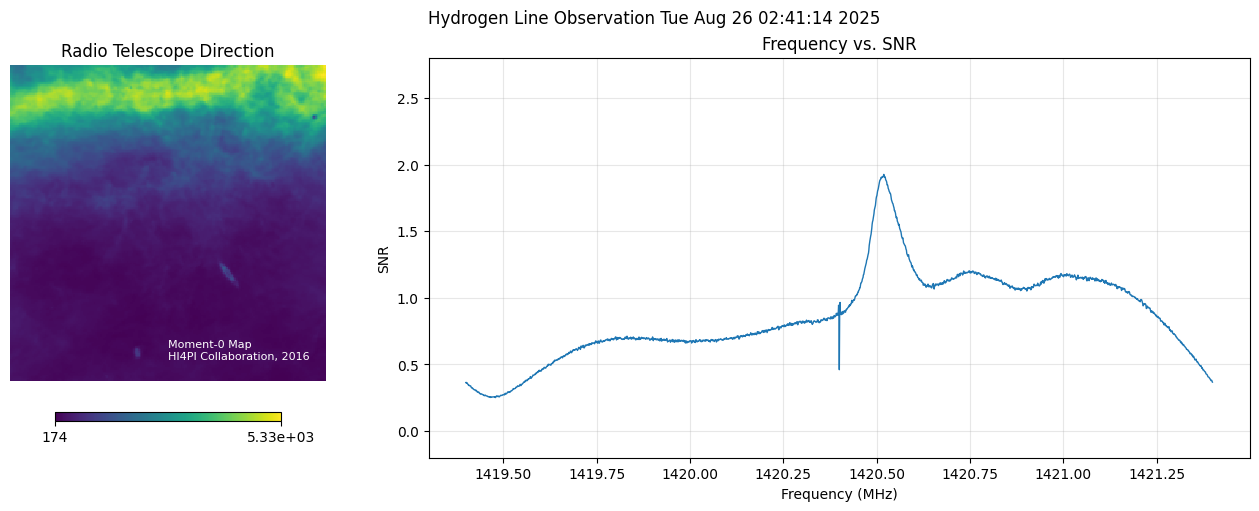

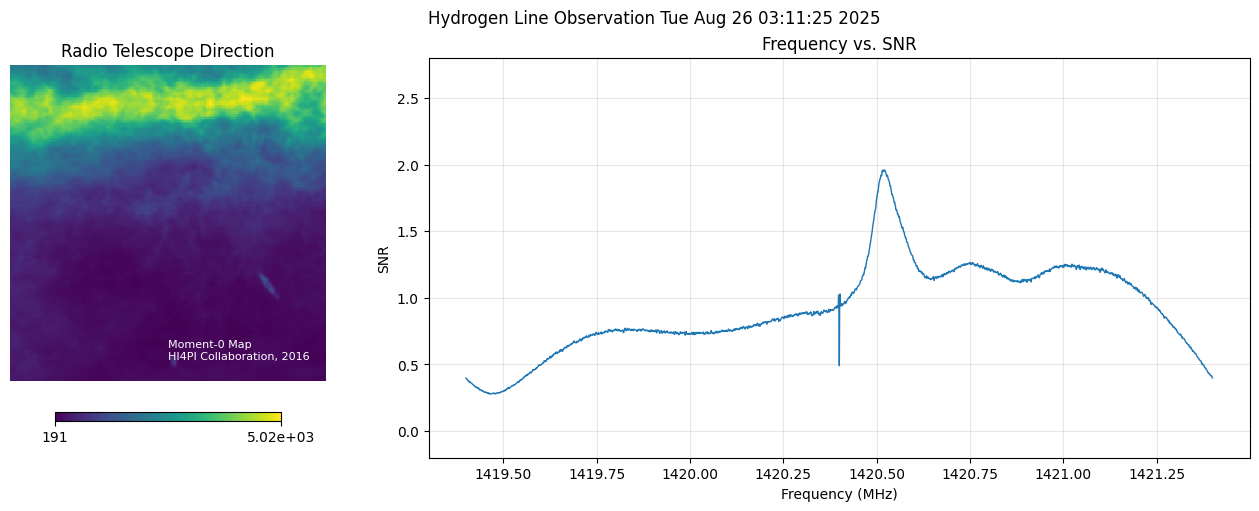

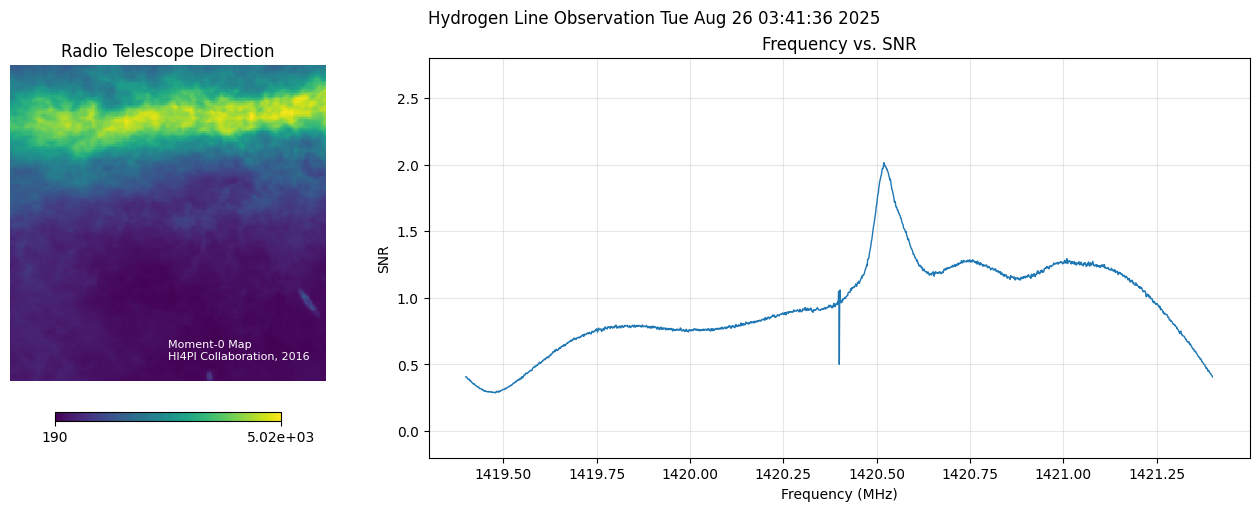

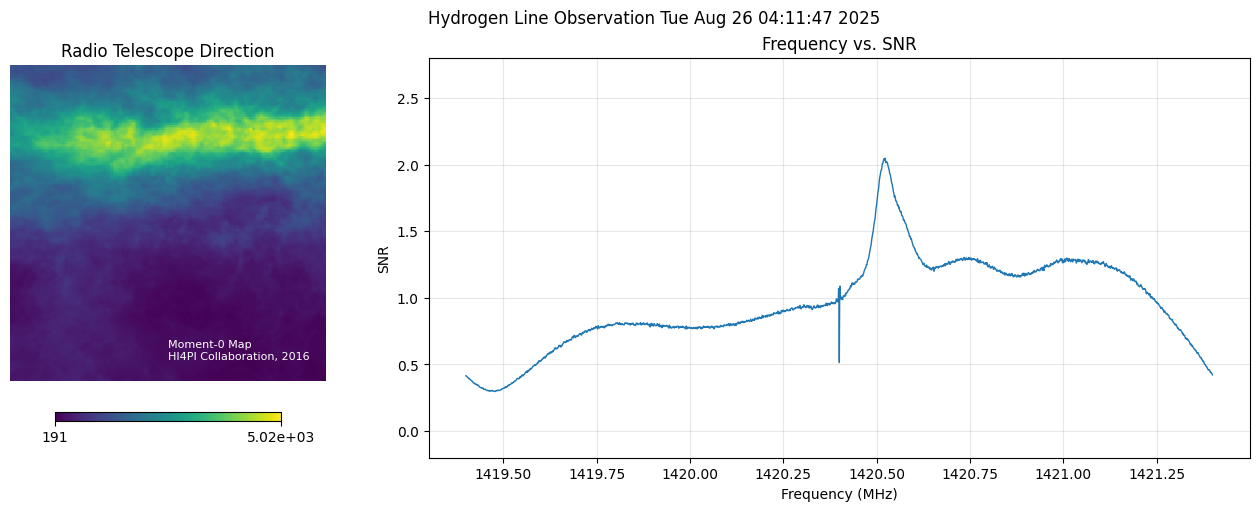

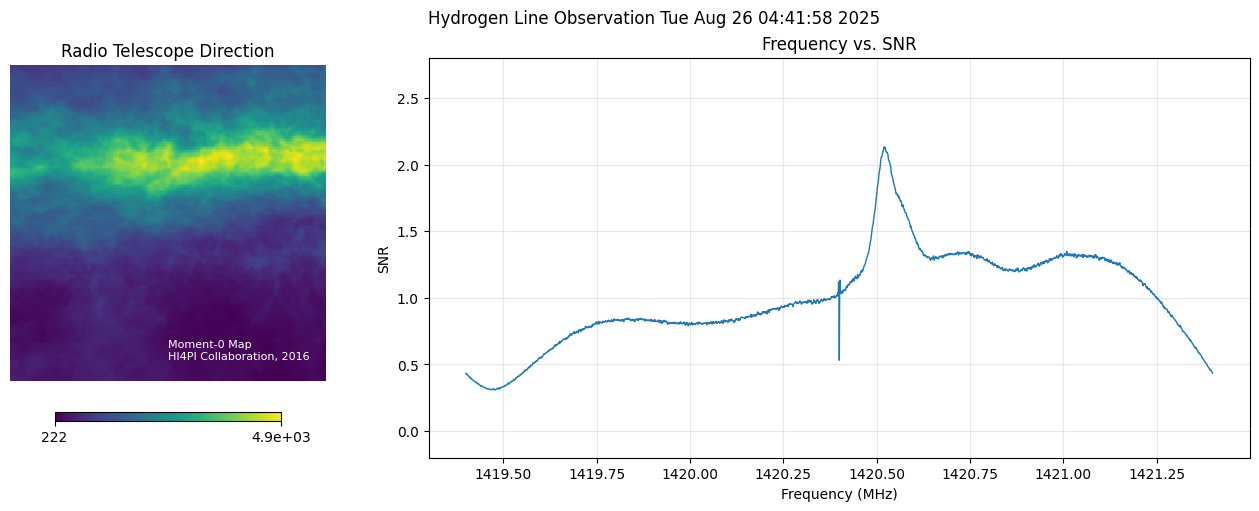

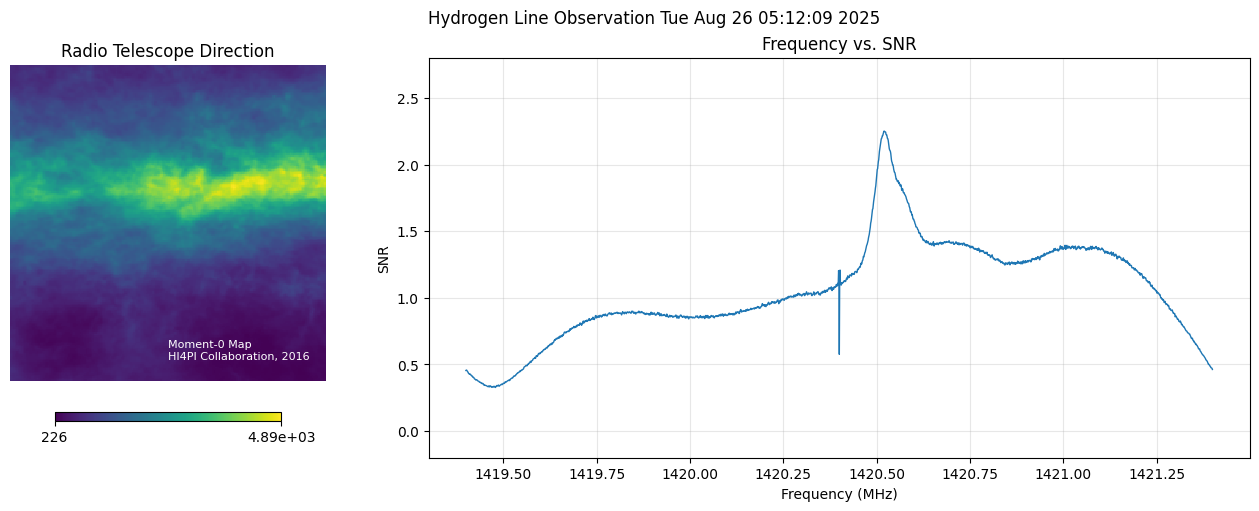

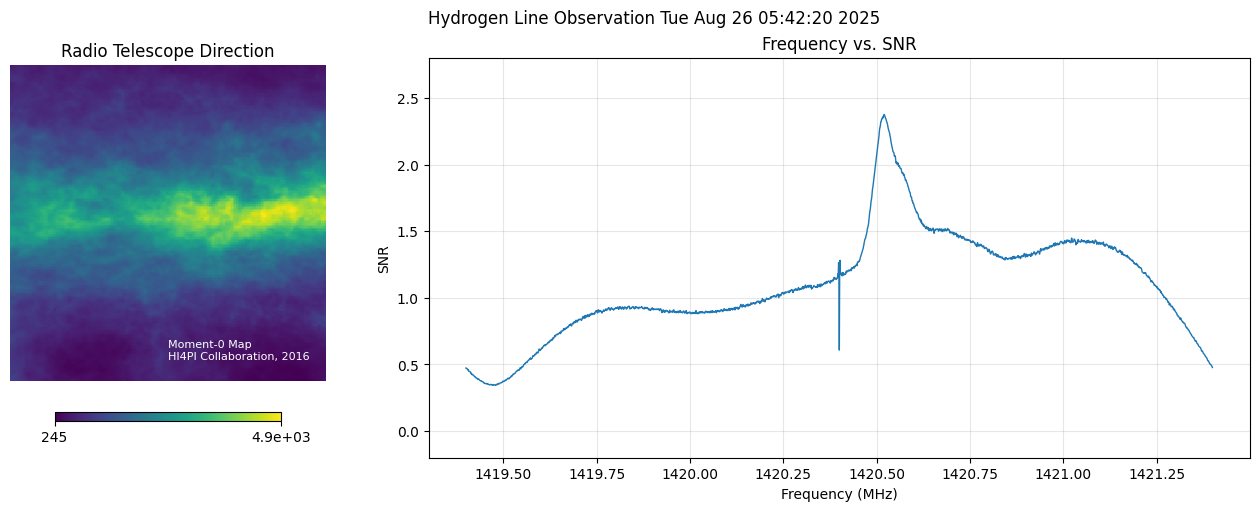

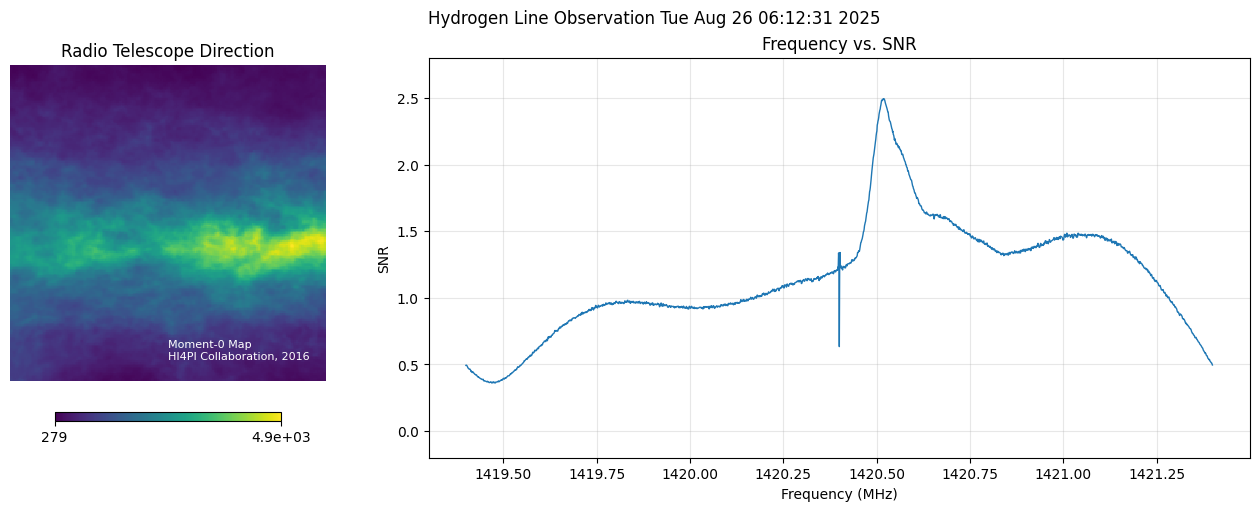

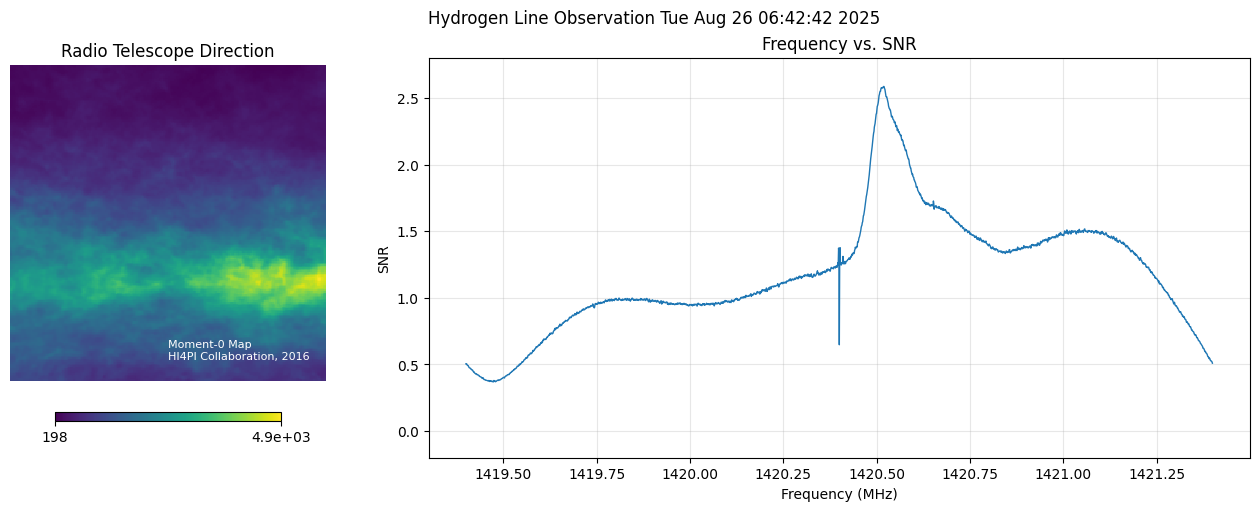

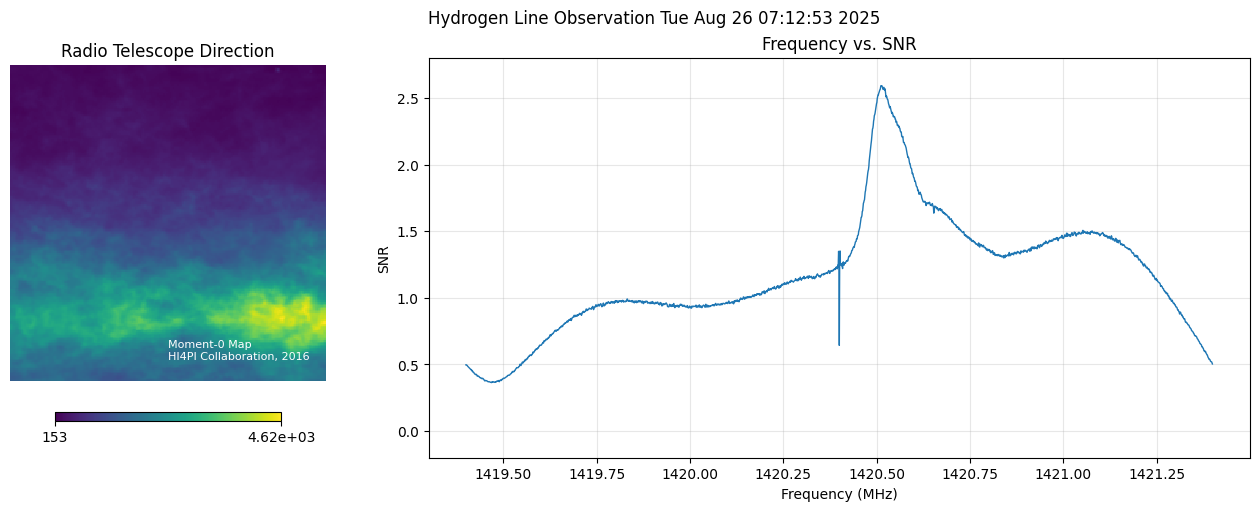

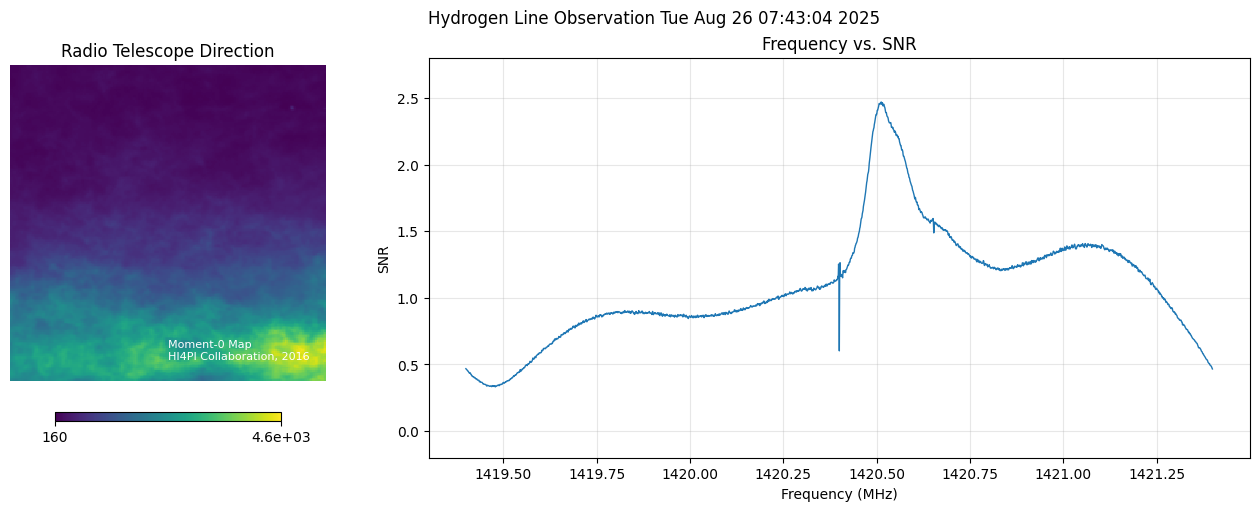

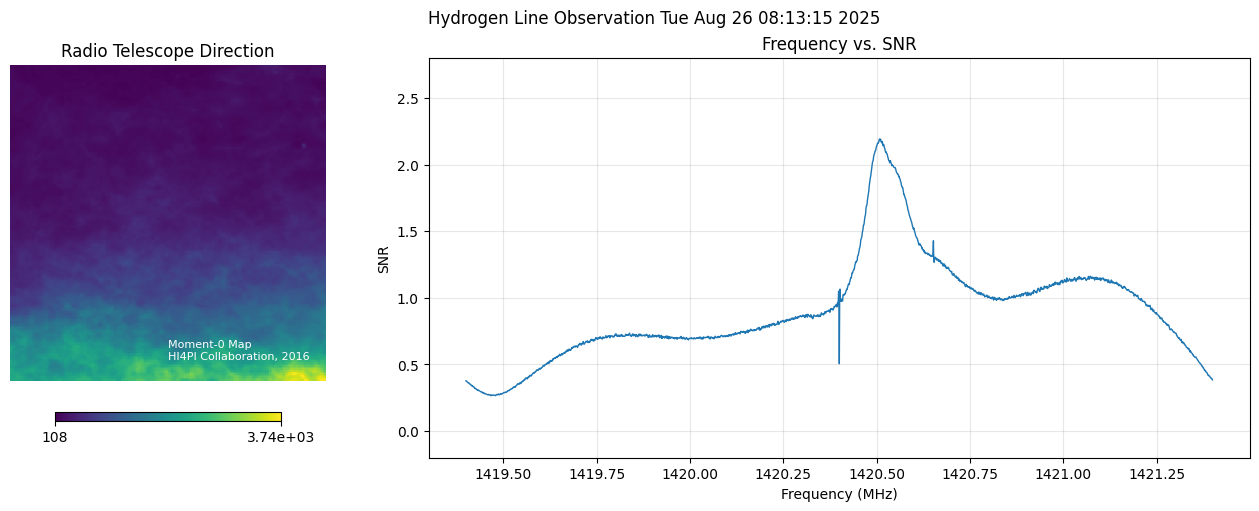

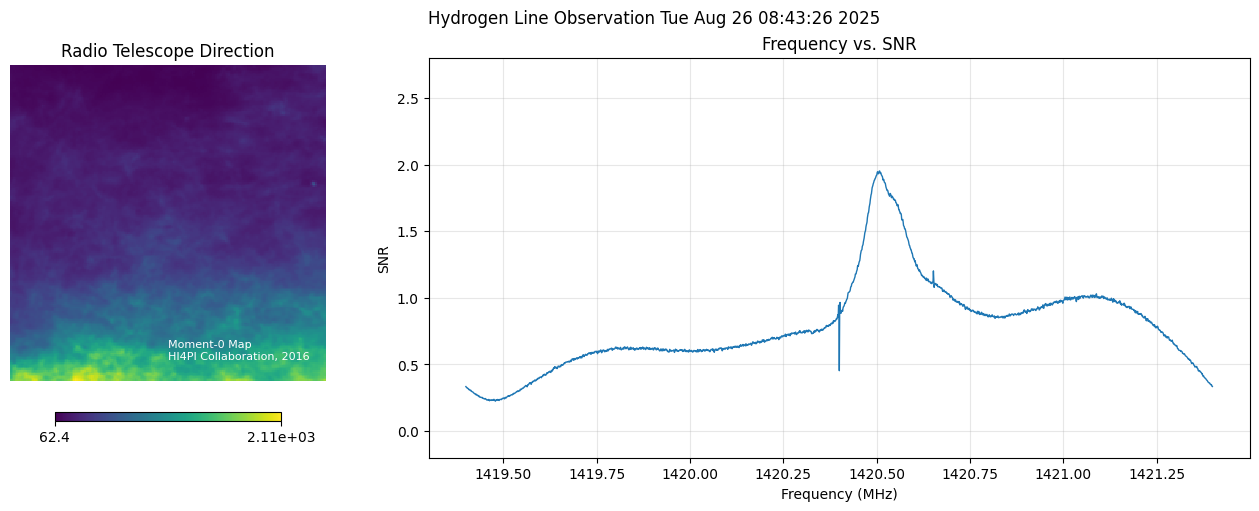

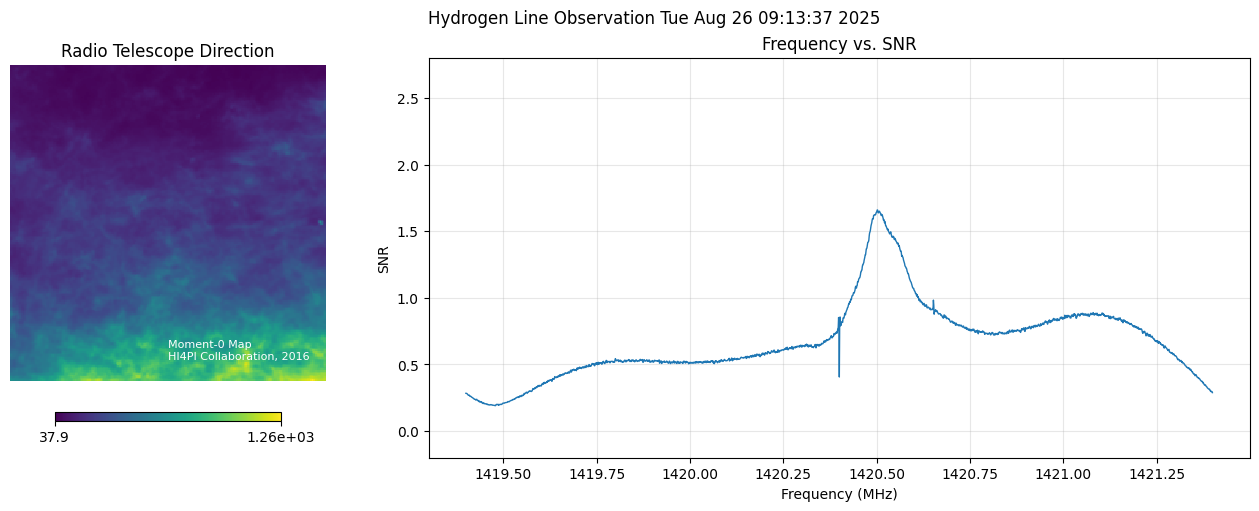

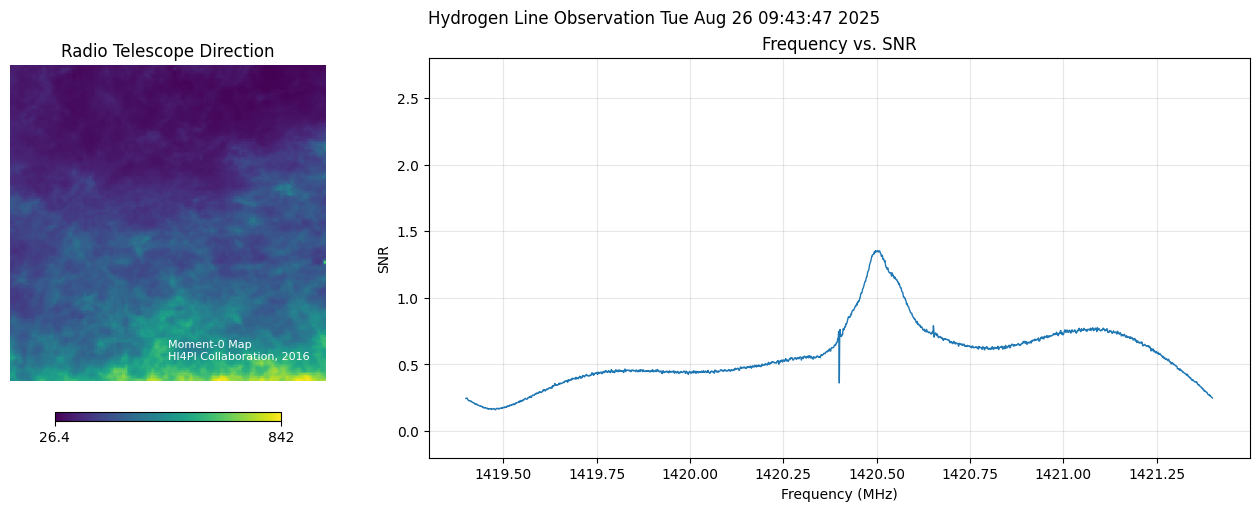

In [284]:
for i in range(len(averaged_spectra_snr)):
    create_spectra(i).savefig("plots/25-aug-2/observation-" + str(i) + ".png", bbox_inches='tight')